In this notebook we will implement a slightly more involve QML model.

Quantum Convolutional Neural Networks (QCNN): QCNNs mimic the structure of classical convolutional networks and try to build efficent models with a smaller number of parameters by subsequent layers of convolutions and pooling on the circuit level.

A QCNN as introduced in https://arxiv.org/abs/1810.03787 applies a _general two qubit unitary to all neighboring qubits_. The two qubit unitarity thereby acts as the filter of the CNN.
After a convolutional layer, a pooling operation essentially reduces two qubits to a single one.
Schematically a QCNN would therefore look like this:

![qcnn.png](https://drive.google.com/uc?id=1RkZ4Jts5FwopNBMRjMFWPBF_LoUtpNAN)


In [1]:
!pip install pennylane --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 53.8 MB/s eta 0:00:00


First we import some neccesary packages, we will again use pennylane.

In [2]:
import pennylane as qml
import pennylane.numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Data

We load MNIST as usual

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11490434/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


In [4]:
n_train_per_class = 200
n_test_per_class = 1000

In [5]:
def filter_36(x, y, n_samples):
    keep3 = (y == 3)
    keep6 = (y == 6)
    x = np.concatenate((x[keep3][:n_samples], x[keep6][:n_samples]))
    y = np.concatenate((y[keep3][:n_samples], y[keep6][:n_samples]))
    y = y == 3
    y = 2*y - 1
    return shuffle(x, y, random_state = 0)

In [6]:
x_train, y_train = filter_36(x_train, y_train, n_train_per_class )
x_test, y_test = filter_36(x_test, y_test, n_test_per_class )

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 400
Number of filtered test examples: 1958


1


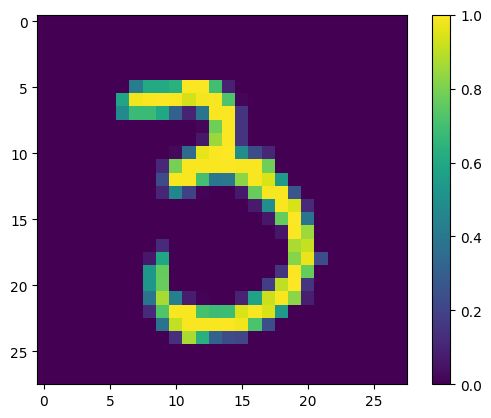

In [7]:
print(y_train[0])

plt.imshow(x_train[0])
plt.colorbar()

In [8]:
n_qubits = 4
n_features = n_qubits

In [9]:
pca = PCA(n_components=n_features)
x_train = pca.fit_transform(x_train.reshape(-1, 28 * 28))
x_test = pca.transform(x_test.reshape(-1, 28 * 28))

In [10]:
norm = np.max(x_train)

x_train = x_train/norm*np.pi
x_test = x_test/norm*np.pi

## QCNN circuits

In [11]:
dev = qml.device('lightning.qubit', wires=n_qubits)

As embedding we will use angle embedding again.

In [12]:
def embedding(data):
  for idx, x in enumerate(data):
    qml.RX(x,wires=idx)

Now we define our pooling operation. It simply consits of single qubit unitaries and a CNOT which controlls on the bit we want to pool out (here called sinkbit). The controlled bit wont be used after the pooling anymore, thereby reducing the circuit to the target bit.

In [13]:
def pool(sinkbit, targetbit, params):
    qml.Rot(params[0], params[1], params[2], wires=sinkbit)
    qml.Rot(params[3], params[4], params[5], wires=targetbit)
    qml.CNOT(wires=[sinkbit,targetbit])
    qml.Rot(params[6], params[7], params[8], wires=targetbit)

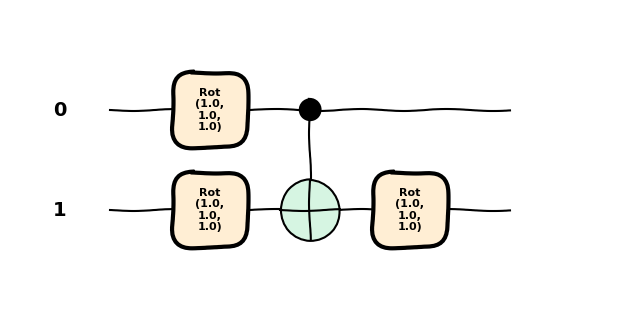

In [14]:
qml.draw_mpl(pool, decimals=1, style="sketch")(0,1,np.ones(9))
plt.show()

We now want to construct a general two qubit unitarity.
We can do so by using [two qubit rotation gates (e.g. rxx)](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html).
Since these gates are not implemented in pennylane, we write functions for them ourselfs.

In [15]:
def RXX(angle, wires):
    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[1])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RZ(angle, wires=wires[1])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[1])

def RYY(angle, wires):
    qml.RX(np.pi/2, wires=wires[0])
    qml.RX(np.pi/2, wires=wires[1])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RZ(angle, wires=wires[1])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RX(-np.pi/2, wires=wires[0])
    qml.RX(-np.pi/2, wires=wires[1])


def RZZ(angle, wires):
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.RZ(angle, wires=wires[1])
    qml.CNOT(wires=[wires[0],wires[1]])

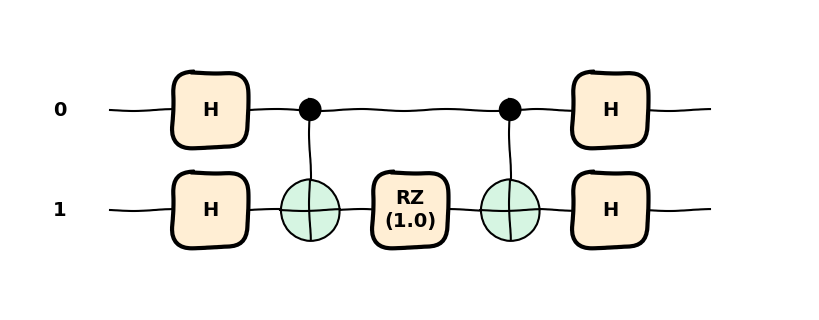

In [16]:
qml.draw_mpl(RXX, decimals=1, style="sketch")(1,[0,1])
plt.show()

In terms of these gates, a general two qubit unitarity is given by:

In [17]:
def conv(qubit0, qubit1, params):
    qml.Rot(params[0], params[1], params[2], wires=qubit0)
    qml.Rot(params[3], params[4], params[5], wires=qubit1)
    RXX(params[6], wires=[qubit0, qubit1])
    RYY(params[7], wires=[qubit0, qubit1])
    RZZ(params[8], wires=[qubit0, qubit1])
    qml.Rot(params[9], params[10], params[11], wires=qubit0)
    qml.Rot(params[12], params[13], params[14], wires=qubit1)

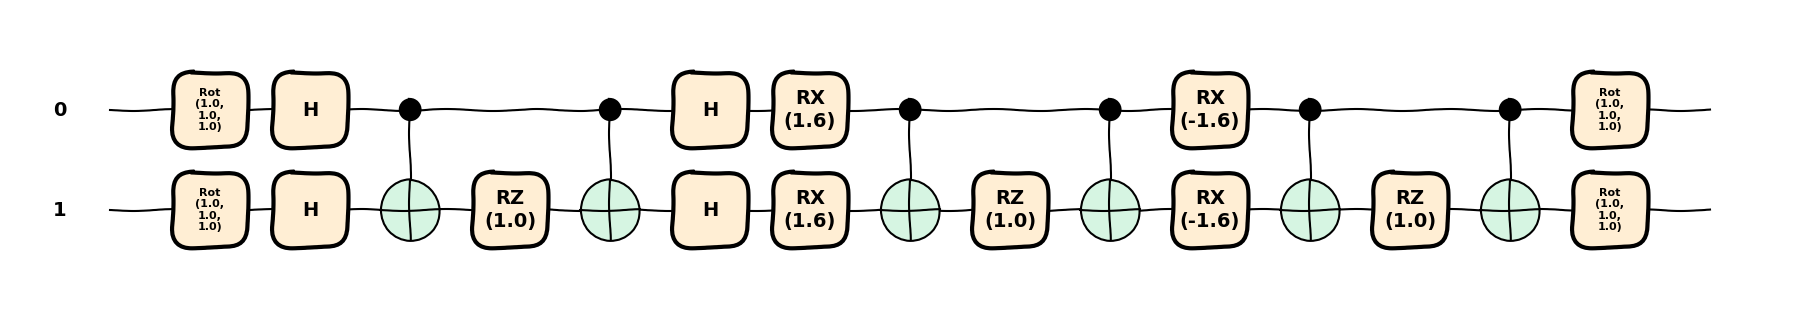

In [18]:
qml.draw_mpl(conv, decimals=1, style="sketch")(0,1,np.ones(15))
plt.show()

### Exercise: Two qubit unitarity



How many parameters does a general two qubit gate neccersarily have?

Bonus:
Can you show that the circuit above is a general two qubit unitarity? You might have to look up the matrices of these gates for that [RXX](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html) [RYY](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RYYGate.html) [RZZ](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZZGate.html)):

As you can see, this is already a pretty deep circuit.

We construct a single layer by applying the convolutions and the pooling in the topology displayed above. Note that (like in a convolutional layer) we use the same parameters for avery application of a single filter in a single layer.

In [19]:
def layer(params, wires):
    for idx, wire in enumerate(wires):
        if idx % 2 == 0:
            conv(wire, wire+1, params[:15])
    for idx, wire in enumerate(wires):
        if idx % 2 == 1 and not idx == len(wires)-1:
            conv(wire, wire+1, params[:15])
        if idx == len(wires)-1:
            conv(wire, wires[0], params[:15])

    for idx, wire in enumerate(wires[:int(len(wires)/2)]):
        pool(wire, wire+int(len(wires)/2), params[15:24])

Now a single layer has 24 parameters in total.

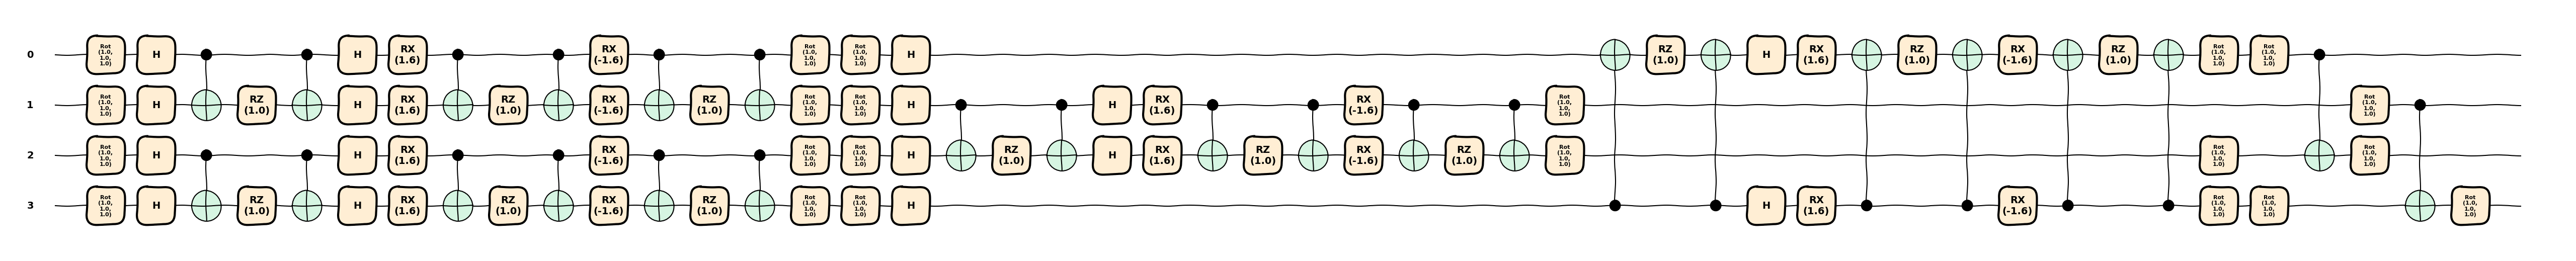

In [20]:
qml.draw_mpl(layer, decimals=1, style="sketch")(np.ones(24), range(n_qubits))
plt.show()

For the full circuit we apply these convolutional layers subsequently pooling out the first half of the qubits.

In [21]:
def model_pqc(params):
    layer(params[:24], wires=range(n_qubits))
    layer(params[24:48], wires=[2,3])

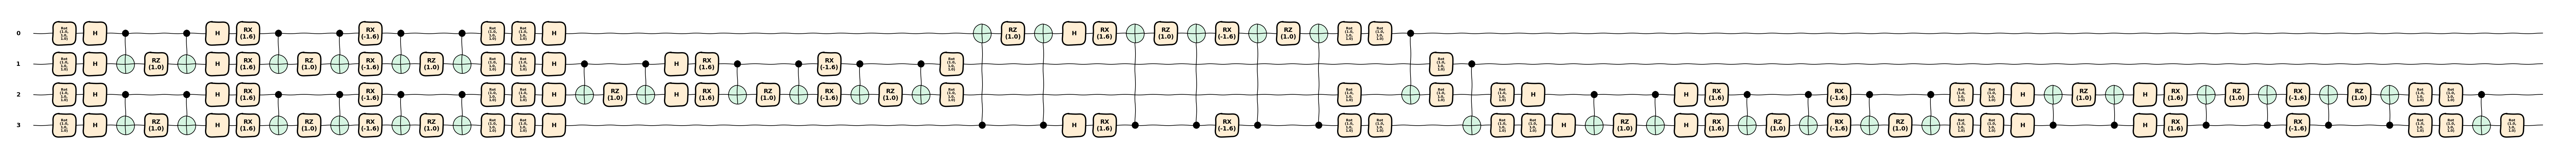

In [22]:
qml.draw_mpl(model_pqc, decimals=1, style="sketch")(np.ones(2*24))
plt.show()

Now this is a deep circuit!
To finalize, we include the data embedding and measure the last qubit in the end.

In [23]:
@qml.qnode(dev)
def training_circuit(data, params, wires):
  embedding(data)
  model_pqc(params)
  return qml.expval(qml.PauliZ(wires[-1]))

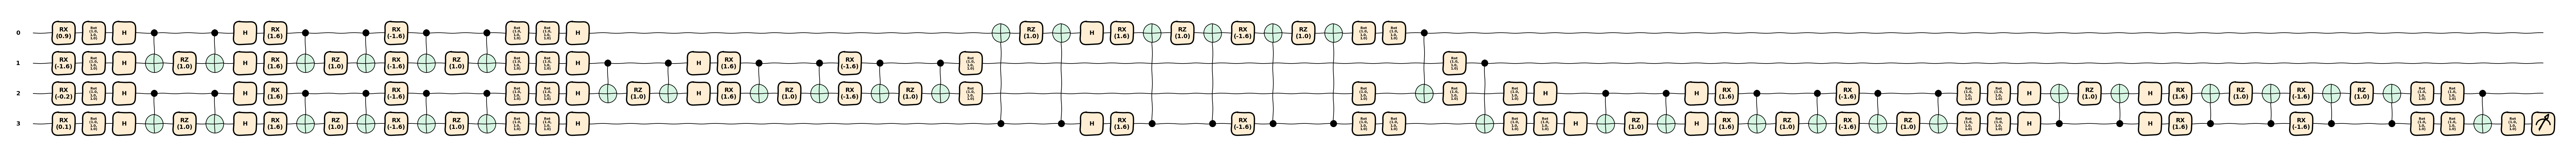

In [24]:
qml.draw_mpl(training_circuit, decimals=1, style="sketch")(x_train[0], np.ones(2*24),range(n_qubits))
plt.show()

# Training

In [25]:
def loss(batch_x, batch_y, params, wires):
  loss = 0
  for idx, x in enumerate(batch_x):
    y_pred = training_circuit(x,params, wires)
    loss += np.maximum(1 - batch_y[idx] * y_pred, 0)
  return loss / len(batch_x)

The rest of the training is similar to the previous examples

In [26]:
params = np.array(np.random.uniform(size=24*2), requires_grad=True)*np.pi

In [27]:
def iterate_minibatches(dataX, dataY, batch_size):
    for start_idx in range(0, dataX.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield dataX[idxs], dataY[idxs]

In [28]:
def accuracy(dataX, dataY, params):
  acc = 0
  for idx, x in enumerate(dataX):
    pred = -1 if training_circuit(x, params, wires=range(n_qubits)) < 0 else 1
    if pred == dataY[idx]: acc += 1
  return acc / len(dataX)

In [29]:
epochs = 10
batch_size = 16
lr = 0.05

In [30]:
opt = qml.AdamOptimizer(stepsize=lr)

In [ ]:
import time
start = time.time()

for it in range(epochs):
    for j,data in enumerate(iterate_minibatches(x_train, y_train, batch_size=batch_size)):
        Xbatch, Ybatch = data
        cost_fn = lambda p: loss(Xbatch, Ybatch, p, wires=range(n_qubits))
        params = opt.step(cost_fn, params)
        print(j, end="\r")

    loss_val = loss(x_train, y_train, params, wires=range(n_qubits))
    acc = accuracy(x_train, y_train, params)

    print(f"Epoch: {it} | Loss: {loss_val:.3} | acc: {acc:.3} ")
    print("____")

end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

Epoch: 0 | Loss: 0.608 | acc: 0.948 
____
Epoch: 1 | Loss: 0.408 | acc: 0.965 
____
Epoch: 2 | Loss: 0.25 | acc: 0.978 
____
Epoch: 3 | Loss: 0.241 | acc: 0.978 
____
